In [1]:
import os, sys
sys.path.append('.')

In [2]:
%matplotlib inline
import jupyanno as ja
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
ja.setup_appmode()
USERNAME = ja._get_user_id()
HOSTNAME = os.environ.get('HOSTNAME', 'anon')

<IPython.core.display.Javascript object>

In [3]:
task_data = ja.read_task_file('task.json')

In [4]:
annot_df = ja.read_annotation(task_data)
print('Showing most recent 3 annotations')
annot_df.tail(3)

Found 351 completed annotations
Showing most recent 3 annotations


,Timestamp,annotation_mode,annotator,comments,commit_info,item_id,label,session,task,time,viewing_info,viewing_time,viewing_info_dict,annotator_class,annotator_name,answer_negativity
348,2018-08-21 14:27:11,BinaryClass,Rad_Victor_Schulze-zachau,,9a96e8559a7760025a869f7c4526213a5dbaf048,00030608_001.png,Yes,jupyter-chestrays-2djupyanno-2dg0jo40zu,Infiltration,1196.792553,"{""viewing_time"": 12.179436206817627}",12.179436,{'viewing_time': 12.179436206817627},Rad,Victor Schulze-zachau,False
349,2018-08-21 14:27:17,BinaryClass,Rad_Victor_Schulze-zachau,,9a96e8559a7760025a869f7c4526213a5dbaf048,00011018_001.png,No,jupyter-chestrays-2djupyanno-2dg0jo40zu,Cardiomegaly,1203.385247,"{""viewing_time"": 6.336434602737427}",6.336435,{'viewing_time': 6.336434602737427},Rad,Victor Schulze-zachau,True
350,2018-08-21 14:27:24,BinaryClass,Rad_Victor_Schulze-zachau,Comments or Feedback?,9a96e8559a7760025a869f7c4526213a5dbaf048,00024435_000.png,No,jupyter-chestrays-2djupyanno-2dg0jo40zu,No Finding,1209.879866,"{""viewing_time"": 6.29765772819519}",6.297658,{'viewing_time': 6.29765772819519},Rad,Victor Schulze-zachau,True


In [5]:
annot_df.groupby(['annotator_class', 'annotator_name']).\
    agg({'viewing_time': ['sum', 'mean'], 'label': len}).\
    reset_index().\
    rename({'label': 'count'}, axis=1).\
    round(2).\
    sort_values(('count', 'len'), ascending=False).\
    style.\
    bar(color='#d65f5f')

In [6]:
results_list = []
# we need to combine the results from binary class and multiclass problems distinctly

for c_mode, group_annot_df in annot_df.groupby('annotation_mode'):
    group_annot_df = group_annot_df.copy()
    group_annot_df['answer'] = group_annot_df['label']
    if c_mode == 'BinaryClass':
        # make the binary result look like a more standard question
        group_annot_df['label'] = group_annot_df.apply(
            lambda c_row: c_row['task'] if c_row['label'] == 'Yes' else None, 1)
    elif c_mode == 'MultiClass':
        pass
    else:
        print('Dashboard does not support {} problems yet!'.format(c_mode))

    c_results_df = pd.merge(group_annot_df,
                            task_data.data_df,
                            how='left',
                            left_on='item_id',
                            right_on=task_data.image_key_col)

    if c_mode == 'BinaryClass':
        c_results_df['correct'] = c_results_df.apply(lambda x: ja.binary_correct(x, task_data.label_col), 1)
    elif c_mode == 'MultiClass':
        c_results_df['correct'] = c_results_df.apply(
            lambda c_row: c_row['label'] == c_row[task_data.label_col], 1)

    results_list += [c_results_df]
results_df = pd.concat(results_list)

# My Personal Results
Here we show the questions you directly answered

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


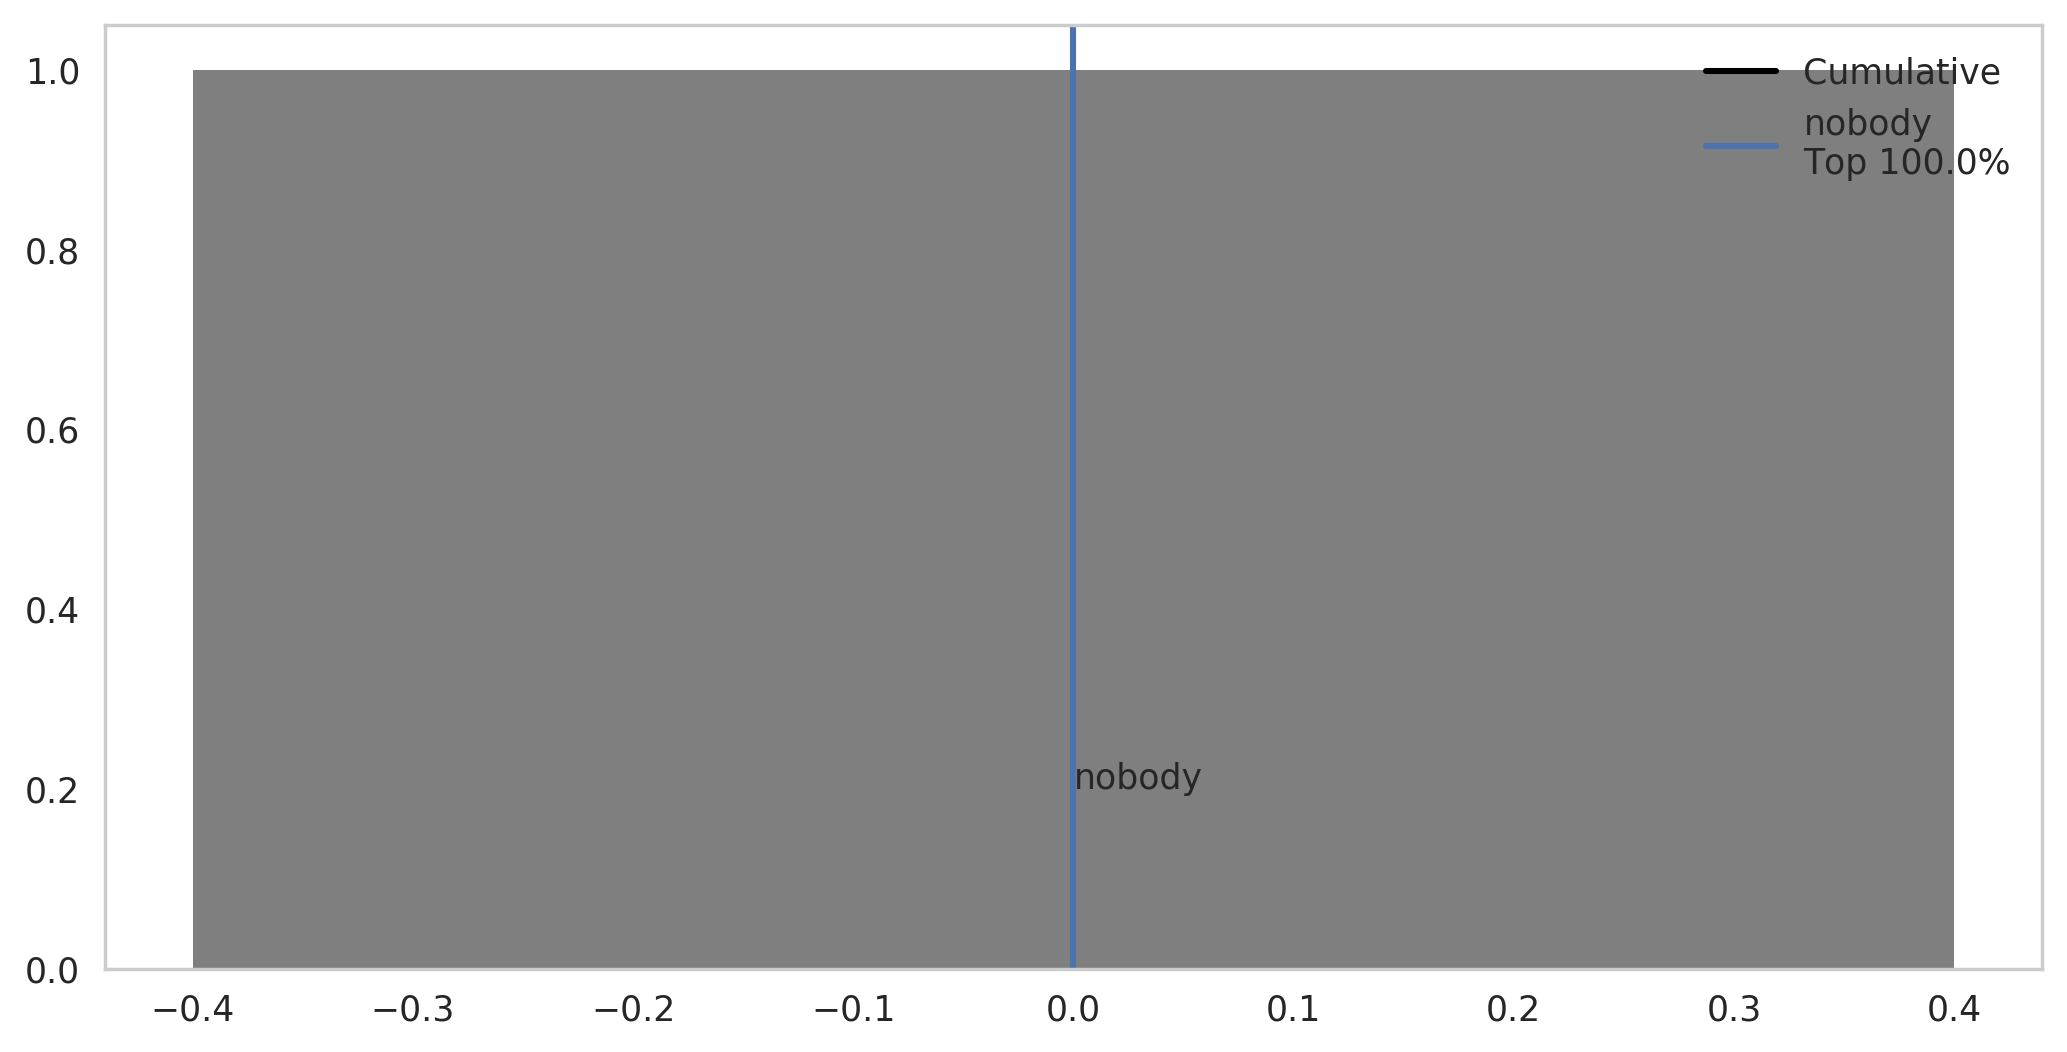

In [7]:
my_answers = results_df[results_df['annotator'] == USERNAME]['correct'].values
ja.show_my_result([USERNAME], [my_answers.sum()], my_answers.shape[0])

In [8]:
my_answers_df = results_df[results_df['annotator'] == USERNAME][[
    'Timestamp', 'correct', task_data.image_key_col, 'task', 'answer', task_data.label_col]].copy()

my_answers_df = my_answers_df.sort_values(
    ['Timestamp'], ascending=True).drop(['Timestamp'], 1)
my_answers_df[task_data.image_key_col] = my_answers_df[task_data.image_key_col].map(
    lambda x: path_to_img(os.path.join(task_data.base_img_dir, x)))
out_html = ja.raw_html_render(my_answers_df.rename({task_data.image_key_col: 'Image',
                                           'task': 'Question',
                                           'answer': 'Your Answer',
                                           task_data.label_col: 'Real Answer'}, axis=1))
from IPython.display import HTML
HTML(out_html)

correct,Image,Question,Your Answer,Real Answer


# Overall Results
We can show the overall results by person / type of user

In [9]:
results_df.groupby(['annotator_class', 'annotator_name']).\
    agg({'viewing_time': 'mean',
         'label': len,
         'correct': lambda x: 100*np.mean(x),
         'answer_negativity': lambda x: 100*np.mean(x)}).\
    reset_index().\
    rename({'label': 'Count',
            'correct': 'Accuracy (%)',
            'viewing_time': 'Average Viewing Time (s)',
            'annotator_class': 'Type of User',
            'annotator_name': 'Name',
            'answer_negativity': 'Negative Responses (%)'}, axis=1).\
    round(1).\
    sort_values('Accuracy (%)', ascending=False).\
    style.\
    background_gradient(cmap='hot', low=.5, high=0).\
    set_properties(**{'font-size': '12pt'})

,Type of User,Name,Average Viewing Time (s),Count,Accuracy (%),Negative Responses (%)
4,Rad,Thomasjohannes Weikert,11.1,101,76.2,81.2
0,Rad,Bram Stieltjes,7.3,50,74,80
2,Rad,Constantinos Anastasopoulos,14.4,50,74,76
1,Rad,Christianalexander Lechtenboehmer,14.2,50,72,70
3,Rad,Maurice Pradella,6.6,50,70,62
5,Rad,Victor Schulze-zachau,23.9,50,52,58


## Disease to be identified 
Here we show the breakdown based on which condition the patient actually had

In [10]:
results_df.groupby(task_data.label_col).\
    agg({'viewing_time': 'mean', 'label': len, 'correct': lambda x: 100*np.mean(x)}).\
    reset_index().\
    rename({'label': 'count',
            'correct': 'Accuracy (%)',
            'viewing_time': 'Average Viewing Time (s)'
            }, axis=1).\
    round(1).\
    sort_values('Accuracy (%)', ascending=False).\
    style.\
    background_gradient(cmap='hot', low=.5, high=0).\
    set_properties(**{'font-size': '12pt'})

,Finding Labels,Average Viewing Time (s),count,Accuracy (%)
2,Infiltration,13.4,61,83.6
0,Cardiomegaly,12.8,70,80
3,No Finding,11.2,79,69.6
1,Effusion,11.7,73,67.1
4,Pneumothorax,14.6,68,54.4


## Question Asked
Finally we show the breakdown based on the question asked

In [11]:
results_df.groupby('task').\
    agg({'viewing_time': 'mean', 'label': len, 'correct': lambda x: 100*np.mean(x)}).\
    reset_index().\
    rename({'label': 'count',
            'correct': 'Accuracy (%)',
            'viewing_time': 'Average Viewing Time (s)',
            'task': 'Question Asked'
            }, axis=1).\
    round(1).\
    sort_values('Accuracy (%)', ascending=False).\
    style.\
    background_gradient(cmap='hot', low=.5, high=0).\
    set_properties(**{'font-size': '12pt'})

,Question Asked,Average Viewing Time (s),count,Accuracy (%)
4,Pneumothorax,16.8,78,76.9
3,No Finding,11,76,73.7
0,Cardiomegaly,8.3,74,71.6
1,Effusion,16.5,63,68.3
2,Infiltration,10.9,60,60


# Results vs Random Guesses
Show the results vs Random Guesses for each user

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


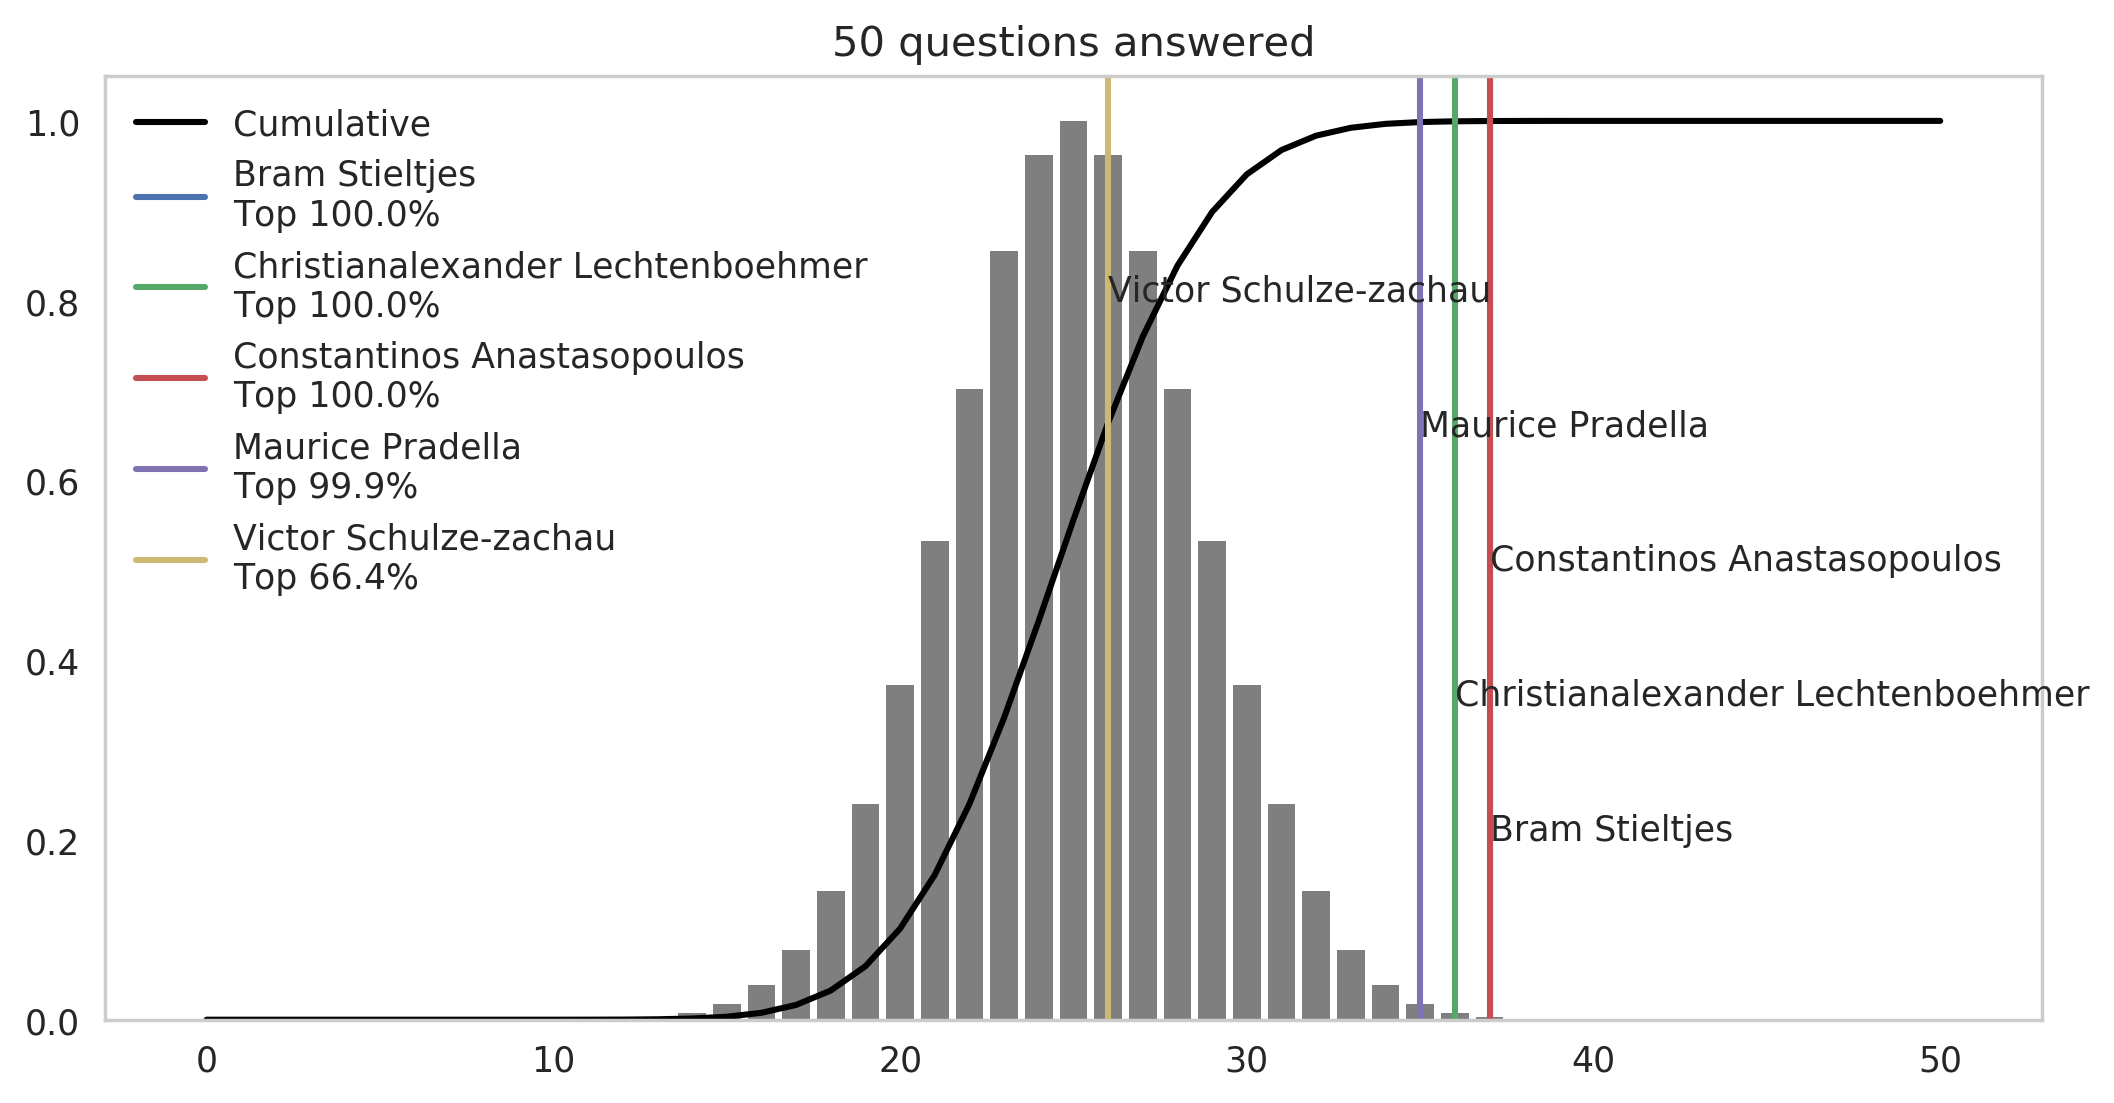

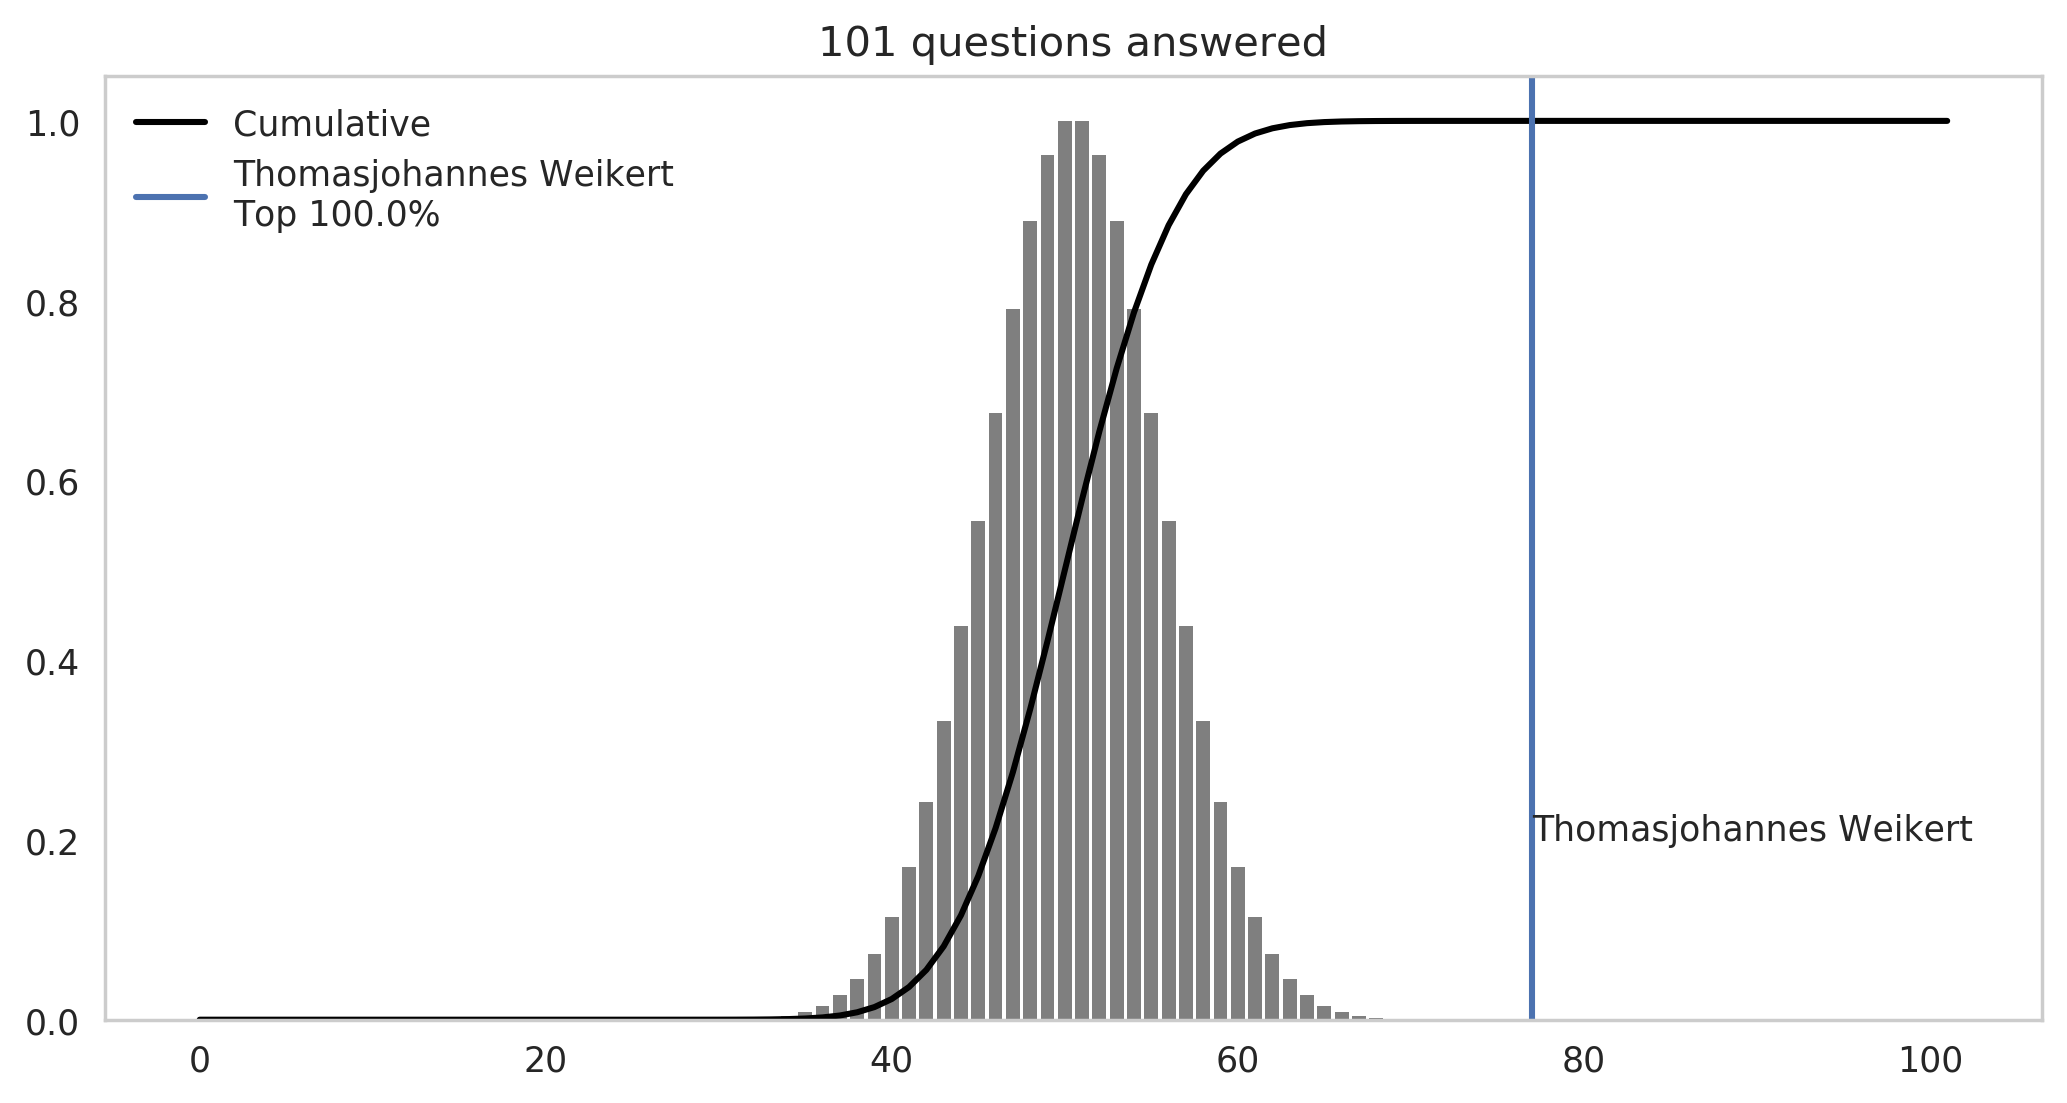

In [12]:
res_df = results_df.groupby(['annotator', 'annotator_name']).\
    agg({'Timestamp': 'count', 'correct': 'sum'}).\
    reset_index().\
    rename({'Timestamp': 'count'}, axis=1)
for count, c_df in res_df.groupby('count'):
    ax1 = ja.show_my_result(c_df['annotator_name'].values.tolist(),
                         c_df['correct'].values.astype(int).tolist(),
                         count)
    ax1.set_title('{} questions answered'.format(count))

# Export Results
The full results can be exported and viewed in Excel or Google Sheets and analyzed even further

In [13]:
results_df.to_csv('results.csv', index=False)
from IPython.display import FileLink
print('Download Results')
FileLink('results.csv')

Download Results


/home/jovyan/results.csv

# Image Interaction
Here we look at the interaction that took place with the images

In [14]:
from itertools import chain
# flatten out all the zoom results
has_zoom = results_df['viewing_info_dict'].map(lambda x: 'zoom' in x)
zoom_df = results_df[has_zoom].copy()
print(zoom_df.shape[0], 'results with zoom information')
zoom_df['zoom'] = zoom_df.apply(
    lambda c_row: [dict(y, img_idx=c_row.name)
                   for y in c_row['viewing_info_dict']['zoom']
                   if ('x' in y) and ('y' in y)],
    axis=1
)
zooms_df = pd.DataFrame(list(chain(*zoom_df['zoom'].values.tolist())))
zooms_df['img_cat'] = pd.factorize(zooms_df['img_idx'])[0]

124 results with zoom information


/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


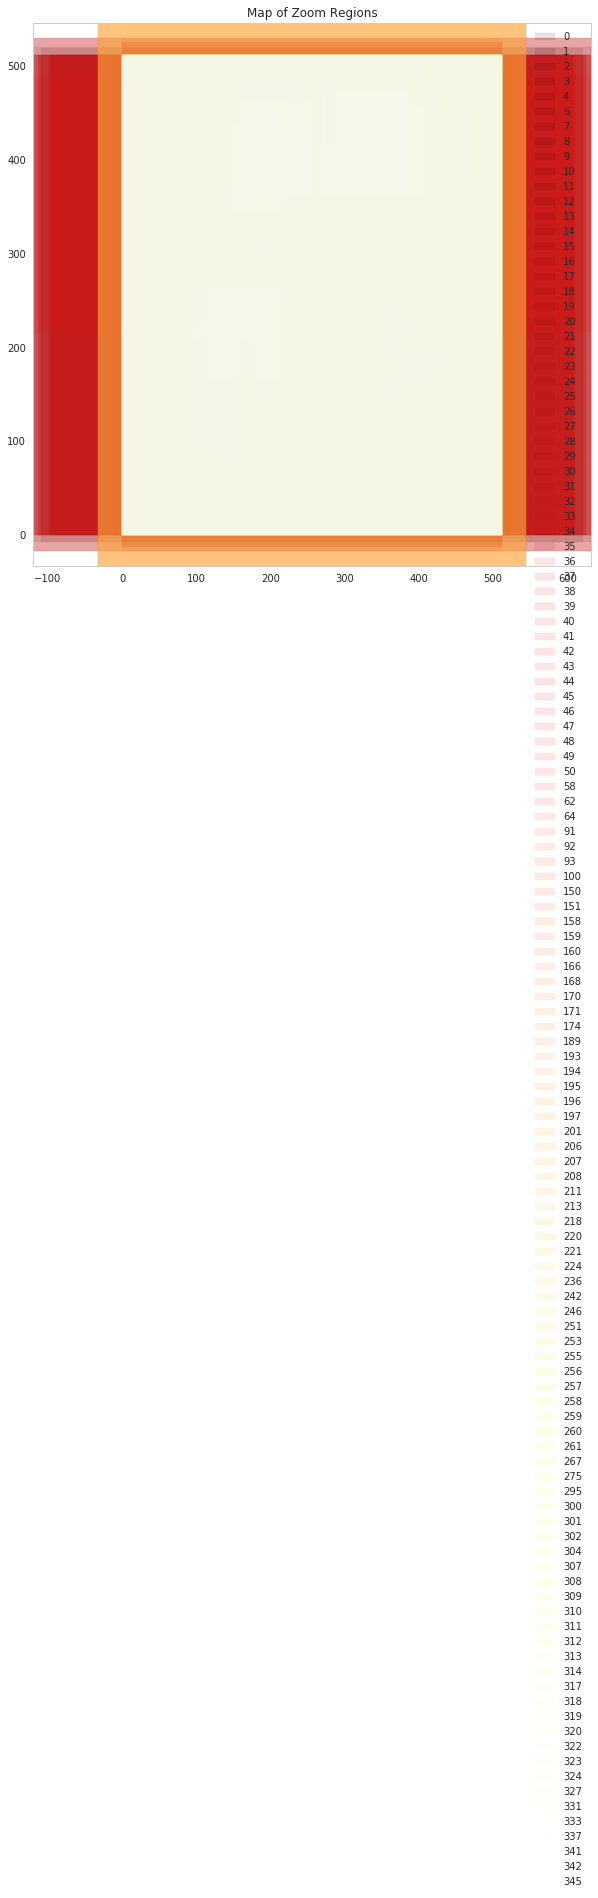

In [15]:
from matplotlib.patches import Rectangle
for col_name in 'xy':
    for i in range(2):
        zooms_df['{}_{}'.format(col_name, i)] = zooms_df[col_name].map(
            lambda x: x[i])
    zooms_df['d_{}'.format(col_name, i)] = zooms_df[col_name].map(
        lambda x: max(x)-min(x))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.set_xlim([zooms_df['x_0'].min(), zooms_df['x_1'].max()])
ax1.set_ylim([zooms_df['y_0'].min(), zooms_df['y_1'].max()])
max_cat = zooms_df['img_cat'].max()


for c_idx, c_rows in zooms_df.groupby('img_idx'):
    bonus_args = {'label': c_idx}
    for _, c_row in c_rows.iterrows():
        ax1.add_patch(Rectangle(xy=(c_row['x_0'], c_row['y_0']),
                                width=c_row['d_x'], height=c_row['d_y'],
                                color=plt.cm.hot(c_row['img_cat']/max_cat),
                                **bonus_args,
                                alpha=0.1))
        bonus_args = {}
ax1.set_title('Map of Zoom Regions')
ax1.legend()

Text(0.5,1,'Pixels visible vs Interaction Count')

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


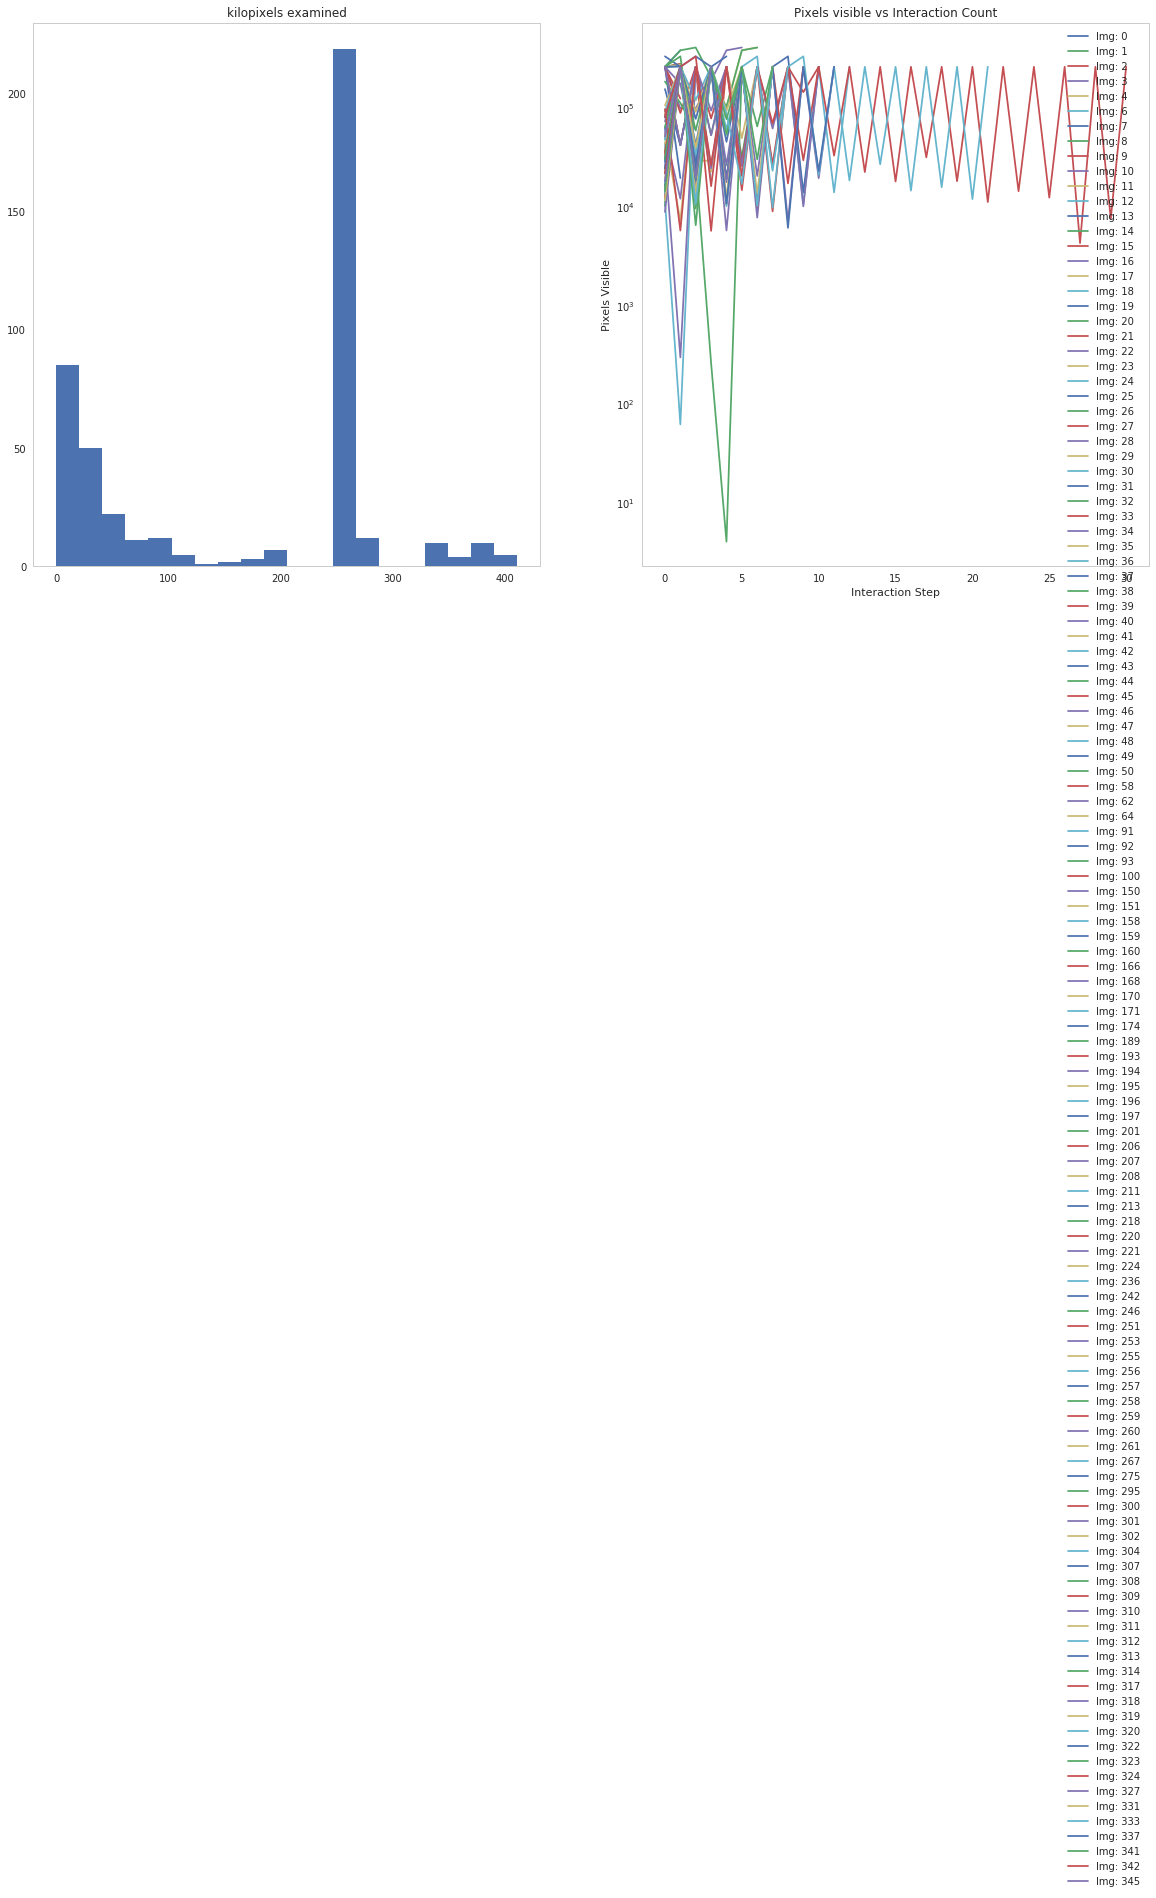

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist((zooms_df['d_x']*zooms_df['d_y'])/1e3, bins=20)
ax1.set_title('kilopixels examined')
for c_idx, c_rows in zooms_df.groupby('img_idx'):
    ax2.semilogy((c_rows['d_x'].values*c_rows['d_y'].values),
                 label='Img: {}'.format(c_idx))
ax2.legend()
ax2.set_xlabel('Interaction Step')
ax2.set_ylabel('Pixels Visible')
ax2.set_title('Pixels visible vs Interaction Count')

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


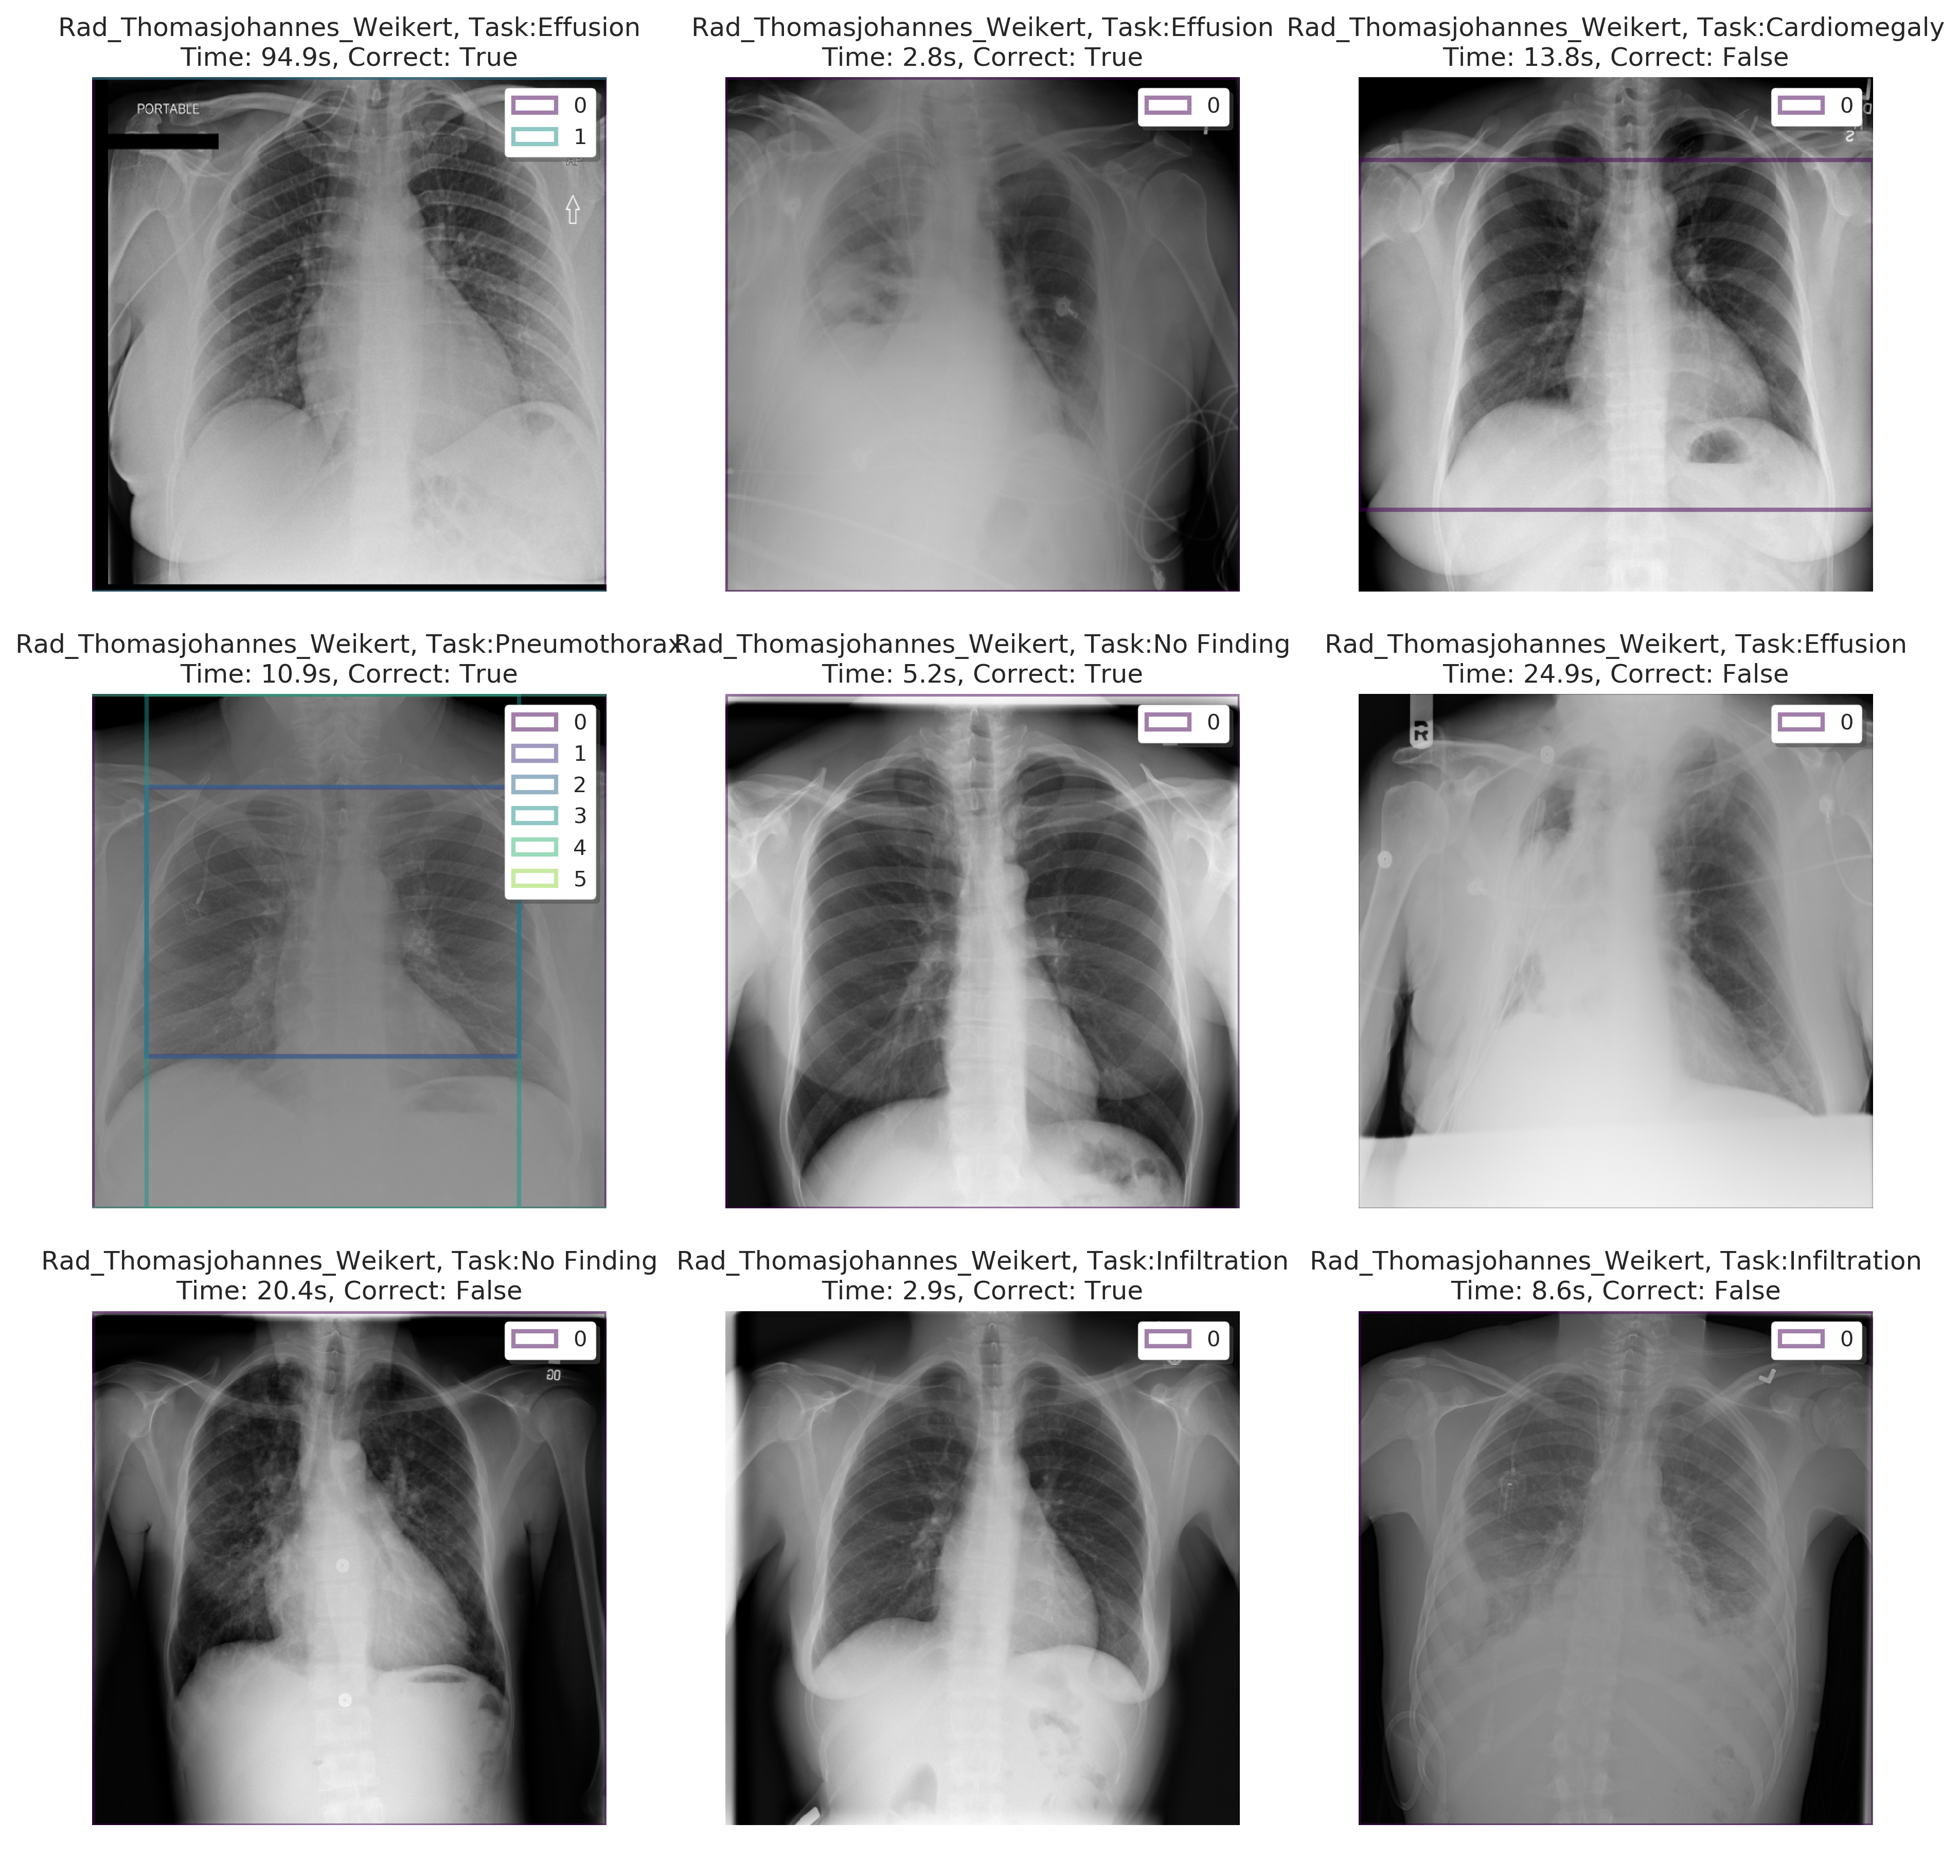

In [17]:
fig, m_axs = plt.subplots(3, 3, figsize=(15, 15), dpi=300)
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_ax, (img_idx, zoom_rows) in zip(m_axs.flatten(),
                                      zooms_df.groupby('img_idx')):
    img_row = results_df.loc[img_idx]
    c_img_path = os.path.join(task_data.base_img_dir, img_row[task_data.image_key_col])
    img_data = np.array(Image.open(c_img_path))
    c_ax.imshow(img_data)
    for idx, (_, c_row) in enumerate(zoom_rows.iterrows()):
        c_ax.add_patch(Rectangle(xy=(c_row['x_0'], 
                                     img_data.shape[1]-c_row['y_1']),
                                 width=c_row['d_x'], height=c_row['d_y'],
                                 color=plt.cm.viridis(idx/zoom_rows.shape[0]),
                                 label=str(idx),
                                 linewidth=2,
                                 fill=False,
                                 alpha=0.5))
    c_ax.legend()
    legend = c_ax.legend(loc='upper right', shadow=True, frameon=True)
    # black on black is hard to read
    legend.get_frame().set_facecolor('#FFFFFF')
    c_ax.set_title(
        '{annotator}, Task:{task}\nTime: {viewing_time:2.1f}s, Correct: {correct}'.format(**img_row))

# Other Fun Graphs
Just a few other graphs to look at

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


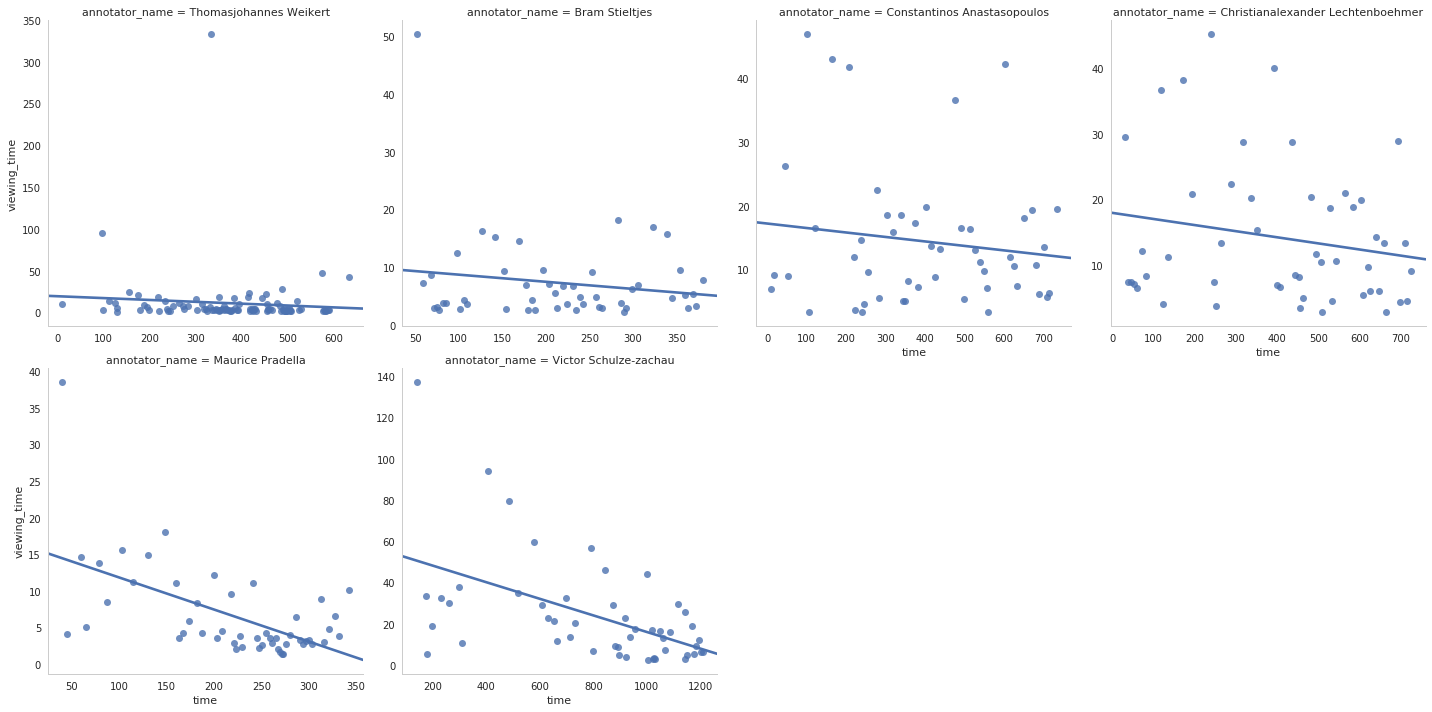

In [18]:
sns.lmplot(x='time',
           y='viewing_time',
           col='annotator_name',
           sharex=False,
           sharey=False,
           col_wrap=4,
           ci=None,
           data=results_df)

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


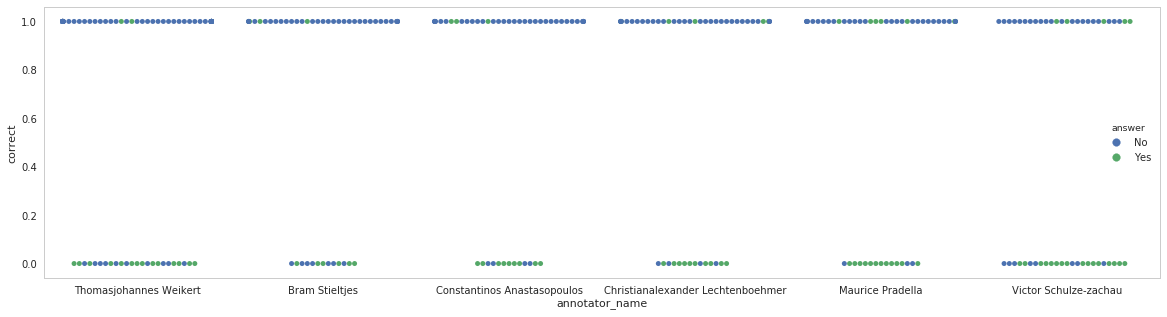

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 5))
sns.swarmplot(x='annotator_name',
              y='correct',
              hue='answer',
              size=5,
              ax=ax1,
              data=results_df)